In [4]:
import sys,os
sys.path.append("../")
import healpy as h
import scipy as sp
from scipy.io.idl import readsav
from modules import get_data as gd     
from modules import dataio_dict as dd
from modules.master import binned_master as bm
from scipy.interpolate import interp1d
from scipy.integrate import quad
import pandas as pd
import collections
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [5]:
bm.binned_master?

# Analysis setup

In [6]:
nside=512
lmax=450
masklmax=2*nside
fwhm_out=40. # arcminutes
deltaell=16

color={}
color[0.0]="tab:blue"
color[0.3]="tab:green"
color[0.6]="tab:orange"
color[0.9]="tab:red"

# Get data

In [146]:
instr=gd.get_litebird_data(only_return_dict=False)
# instr=gd.get_pico_data(only_return_dict=False)

/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//apodized_masks_v2.sav exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//Cls_Planck2018_lensed_scalar.fits exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//smoothed_input_cmb_bmode_map_v2.fits exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//LITEBIRD_CMB_NILC_BB_res40acm.fits exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//LITEBIRD_CMB_NILC_noise_res40acm.fits exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//LITEBIRD_CMB_NILC_BB0m_res40acm.fits exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//LITEBIRD_CMB_NILC_noise0m_res40acm.fits exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments//dataout/litebird//LITEBIRD_CMB_NILC_BB1m_res40acm.fits exists
/Users/adityarotti/Documents/Work/Projects/bmode_moments

<IPython.core.display.Javascript object>


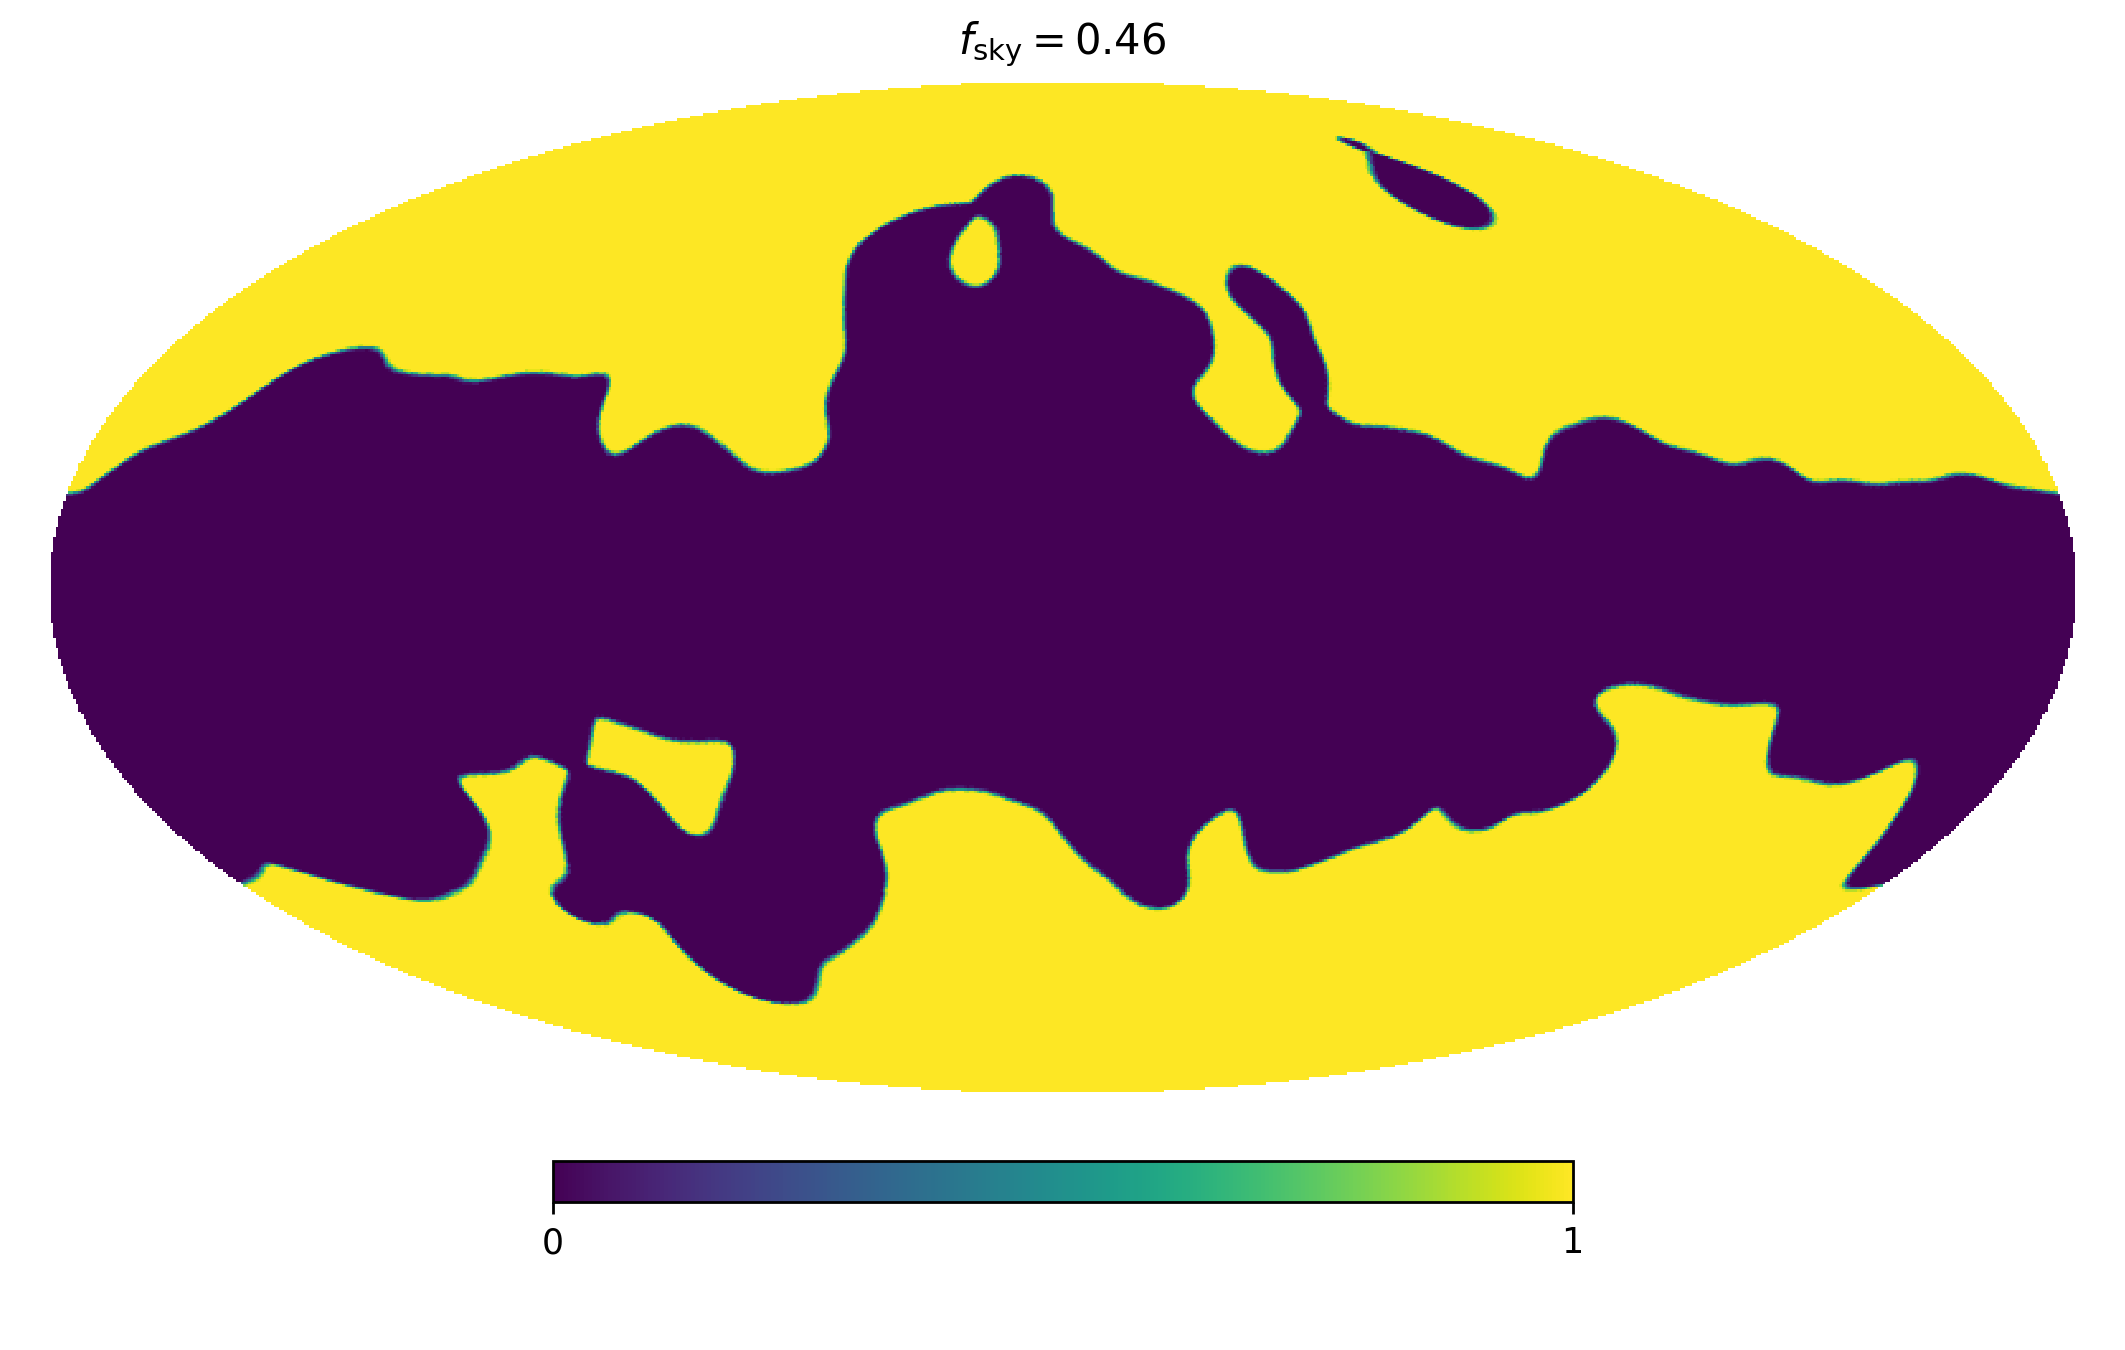

In [147]:
ion()
filename=instr["outdatapath"] + instr["mask_fname"]
vv=readsav(filename) ; mask=vv.apomask1m
# vv=readsav(filename) ; mask=vv.apomask2m1
# filename="../dataout/apodized_masks2m3m_v2.sav"
fsky=sum(mask)/size(mask)
h.mollview(mask,title=r"$f_{\rm sky}=$" + str(round(fsky,2)))

# CMB Master analysis

In [148]:
beam=h.gauss_beam(fwhm=(fwhm_out/60.)*pi/180.,lmax=lmax)*h.pixwin(nside)[:lmax+1]
mtot=bm.binned_master(mask,2,lmax,2*nside,beam=beam,deltaell=deltaell)

In [149]:
clbin={}
# Theory
# data=loadtxt(instr["outdatapath"] + instr["cl_fname"])
data=loadtxt("../../dataout/pico/ffp10_lensedCls.dat")
ell=data[:lmax-1,0] ; cllens=data[:lmax-1,3]
cllens=cllens*2.*pi/(ell*(ell+1))
ell=np.append([0.,1.],ell)
cllens=np.append([0.,0.],cllens)
lbin,clbin["lens"]=mtot.return_binned_spectra(cllens)

data=np.loadtxt("../../dataout/test_tensCls.dat")
ell=data[:lmax+1,0] ; clbb=data[:lmax+1,3]
clbb=clbb*2.*pi/(ell*(ell+1))
ell=np.append([0.,1.],ell)
clbb=np.append([0.,0.],clbb)
lbin,clbin["bb"]=mtot.return_binned_spectra(clbb)

# True CMB
filename=instr["outdatapath"] + instr["cmb_fname"]
cmb=h.read_map(filename,verbose=False)
cl_cmb_raw=h.alm2cl(h.map2alm(cmb*mask,lmax=lmax))
lbin,clbin["cmb"]=mtot.return_bmcs(cl_cmb_raw)

# Data
clbin["res"]={} ; clbin["obs"]={} ; clbin["noise"]={}
for idx in range(len(instr["fnames"].keys())):
    adr="cNILC" + str(idx).zfill(2)
    print adr
    filename=instr["outdatapath"] + instr["fnames"][adr]["cmb"]
    obs=h.read_map(filename,verbose=False)
    clobs=h.alm2cl(h.map2alm(obs*mask,lmax=lmax))
    lbin,cltemp=mtot.return_bmcs(clobs) ; clbin["obs"][adr]=cltemp
    filename=instr["outdatapath"] + instr["fnames"][adr]["noise"]
    nse=h.read_map(filename,verbose=False)
    clobs=h.alm2cl(h.map2alm(nse*mask,lmax=lmax))
    lbin,cltemp=mtot.return_bmcs(clobs) ; clbin["noise"][adr]=cltemp
    obs=obs-cmb-nse
    clobs=h.alm2cl(h.map2alm(obs*mask,lmax=lmax))
    lbin,cltemp=mtot.return_bmcs(clobs) ; clbin["res"][adr]=cltemp
# #     h.orthview((obs-nse-cmb)*mask,title=pico["lbl"][adr],rot=(0,90),norm="hist")

cNILC00
cNILC01
cNILC02
cNILC03
cNILC04
cNILC05
cNILC06
cNILC07
cNILC08
cNILC09
cNILC10
cNILC11
cNILC12
cNILC13
cNILC14


<IPython.core.display.Javascript object>


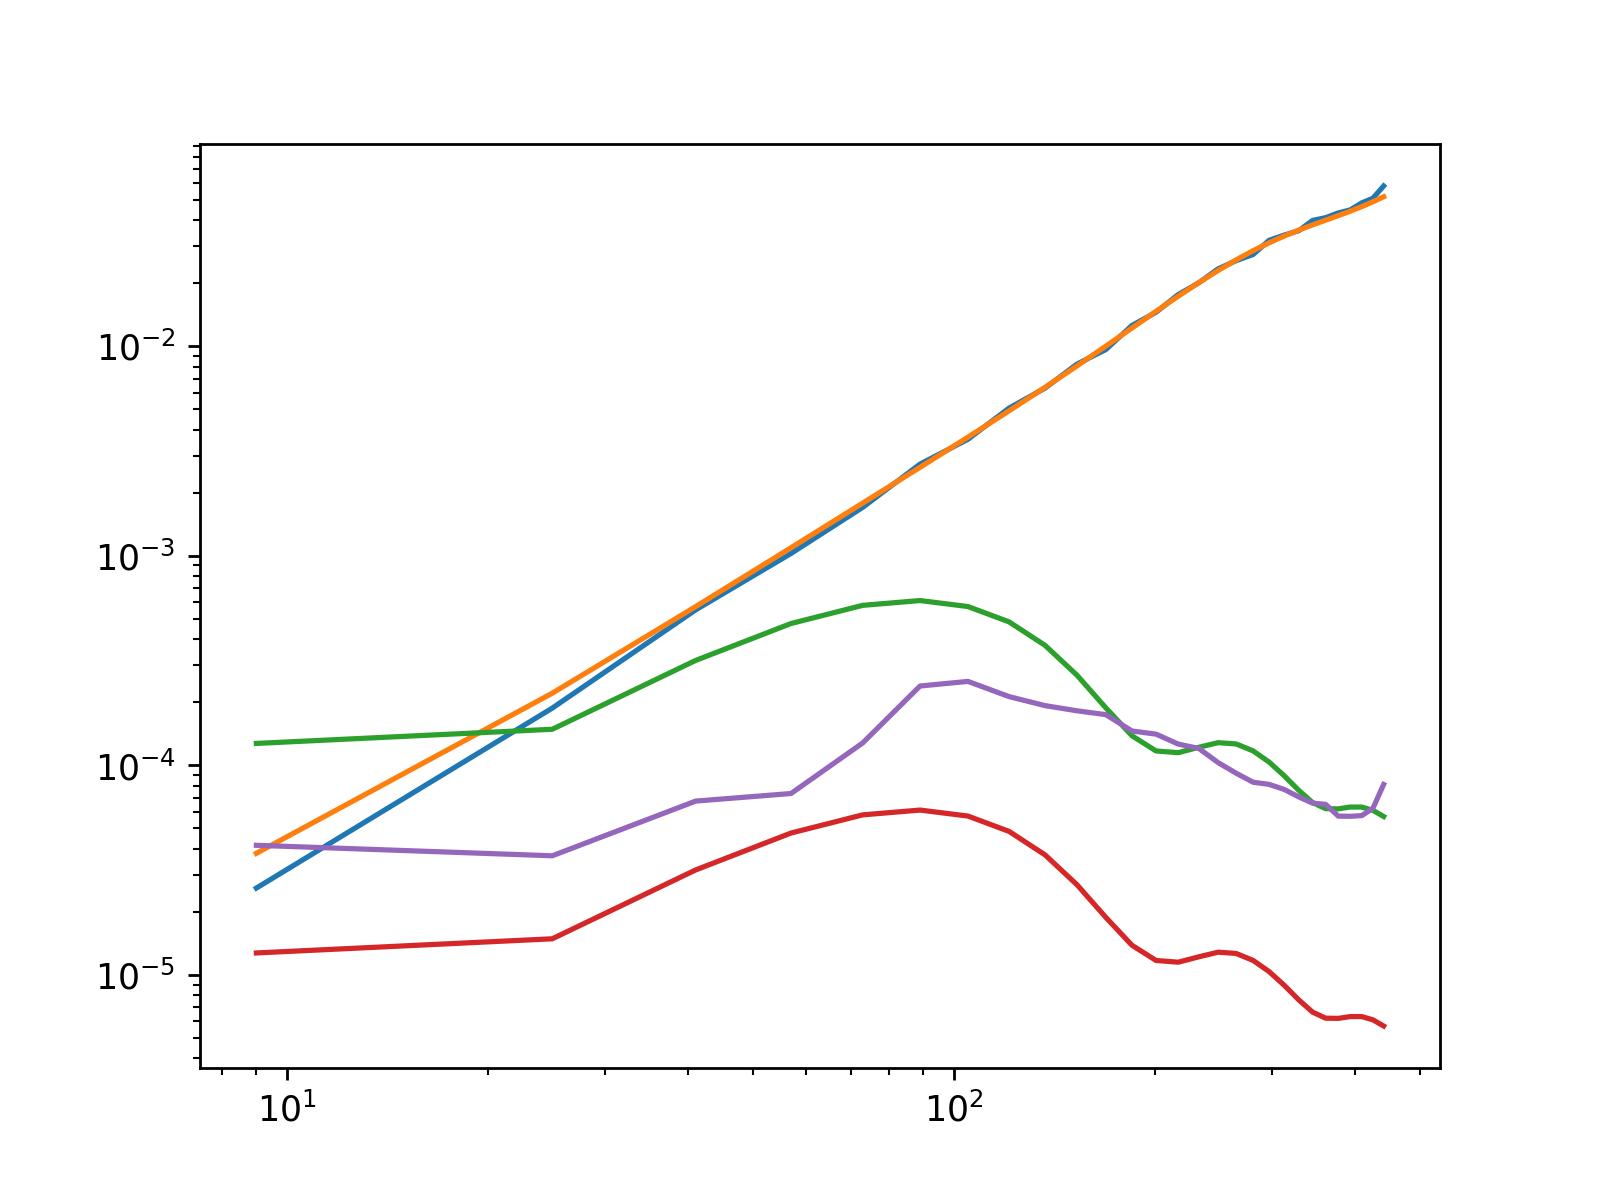

[]

In [150]:
figure()
plot(lbin,clbin["cmb"])
plot(lbin,clbin["lens"])
plot(lbin,1e-2*clbin["bb"])
plot(lbin,1e-3*clbin["bb"])
plot(lbin,clbin["res"]["cNILC04"])
loglog()

In [151]:
rvalue=logspace(-4,-2,1000)
adr="cNILC07" ; Alens=.3
# var_other=((Alens*clbin["cmb"])**2. + clbin["noise"][adr]**2. + clbin["res"][adr]**2.)*(2./((2.*lbin+1)*deltaell*fsky))
var_other=((clbin["obs"][adr] - (1.-Alens)*clbin["cmb"])**2.)*(2./((2.*lbin+1)*deltaell*fsky))
fn = np.vectorize(lambda x : np.exp(-np.sum((clbin["res"][adr]-x*clbin["bb"])**2./var_other)/2.))

In [152]:
x,y=return_chi2(adr,Alens=Alens)

<IPython.core.display.Javascript object>


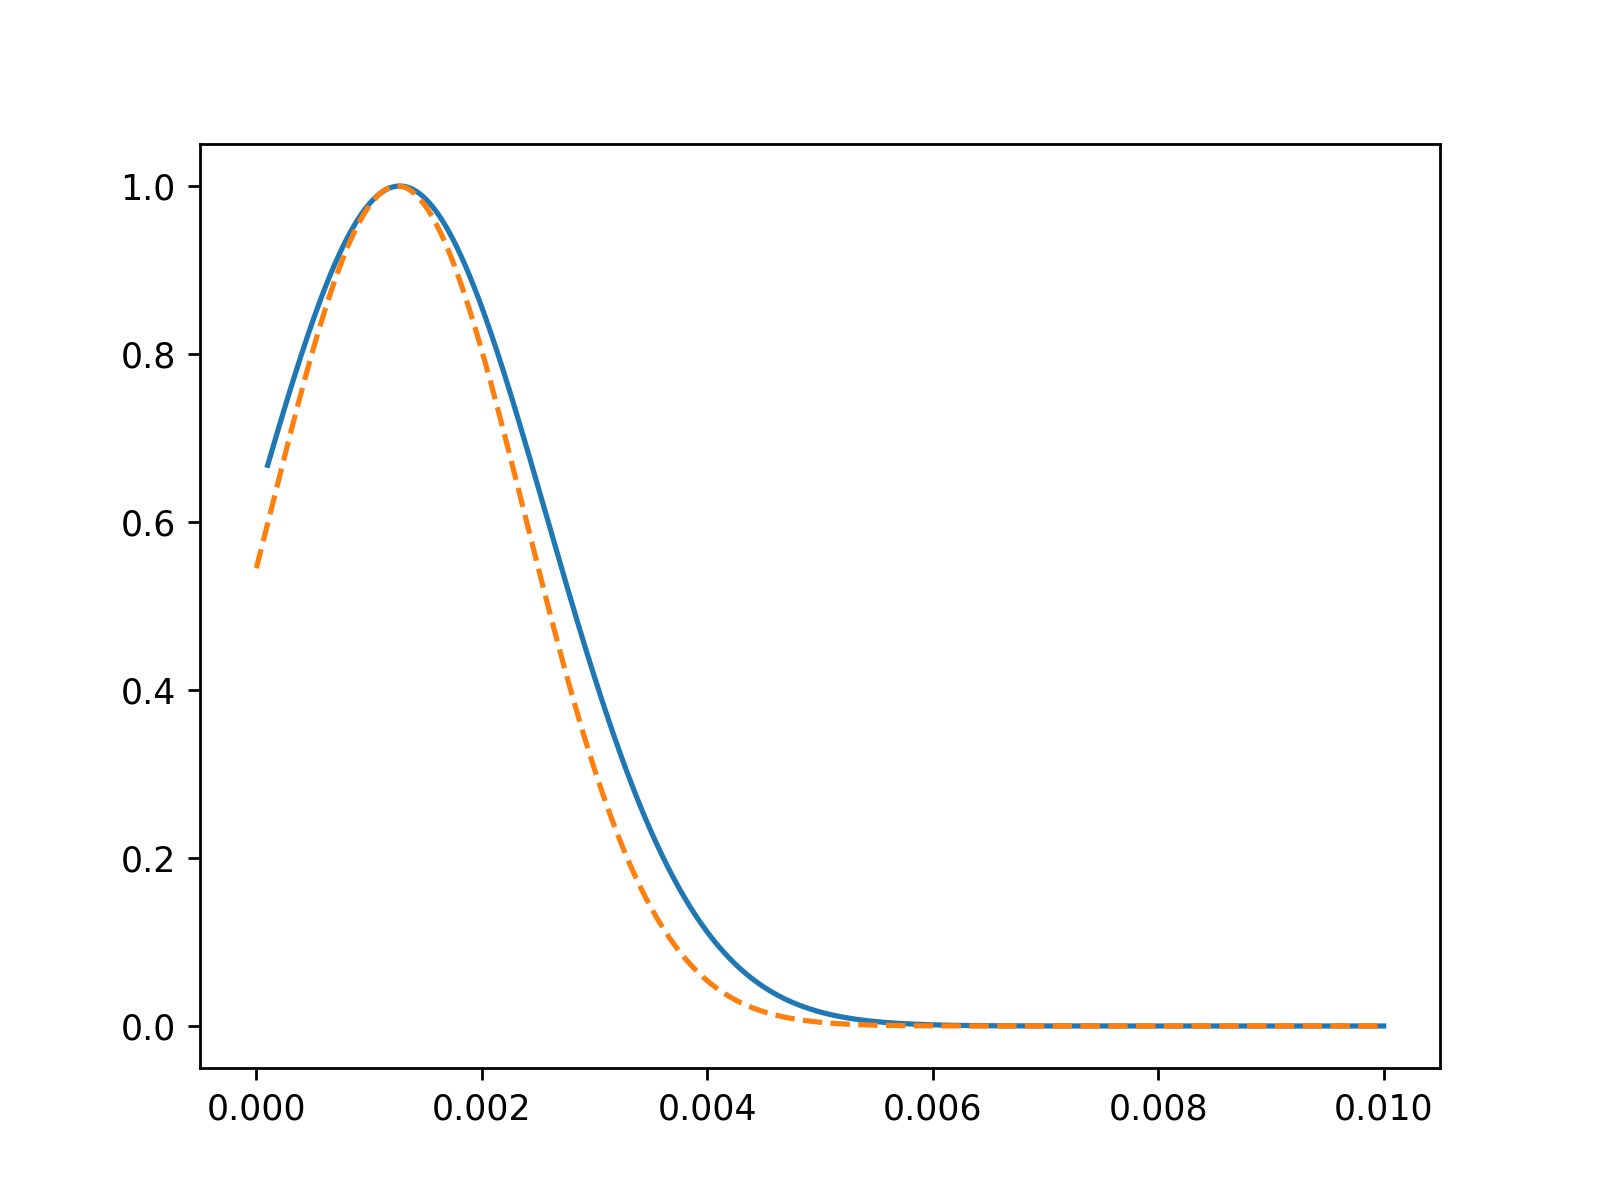

In [153]:
figure()
plot(rvalue,fn(rvalue)/max(fn(rvalue)))
plot(x,y,"--")

# Plots and analysis

In [154]:
def return_chi2(adr,Alens,sampling=1000,res_amp=1.):
    rvalue=logspace(-4,-2,sampling)
    rvalue=np.append(0,rvalue)
    chi2=np.zeros_like(rvalue)
    var_other=(Alens*clbin["cmb"])**2. + clbin["noise"][adr]**2. + res_amp*clbin["res"][adr]**2.
    for ir, r in enumerate(rvalue):
        ddiff=clbin["res"][adr]*res_amp-r*clbin["bb"]
        var=(var_other + (r*clbin["bb"])**2.)
        var=var*(2./((2.*lbin+1)*deltaell*fsky))
        chi2[ir]=np.sum(ddiff**2/var)
#     fn=interp1d(rvalue,exp(-chi2/2.))
#     norm=quad(fn,min(rvalue),max(rvalue))[0]
    return rvalue ,exp(-chi2/2)/max(exp(-chi2/2))

def return_chi2_map(adr,Alens,sampling=1000):
    rvalue=logspace(-4,-2,sampling)
    chi2map=np.zeros((len(rvalue),len(lbin)))
    for ir, r in enumerate(rvalue):
        ddiff=clbin["res"][adr]-r*clbin["bb"]
        var=((Alens*clbin["cmb"])**2. + clbin["noise"][adr]**2. + clbin["res"][adr]**2. + (r*clbin["bb"])**2.)
        var=var*(2./((2.*lbin+1)*deltaell*fsky))
        chi2map[ir,:]=exp(-(ddiff**2/var)/2.)
#     fn=interp1d(rvalue,exp(-chi2/2.))
#     norm=quad(fn,min(rvalue),max(rvalue))[0]
    return rvalue ,chi2map

def return_r_stat(x,y,sigma=0.66,sampling=100):
    max_idx=np.where(y==max(y))[0][0]
    rbias=x[max_idx]
    xl=x[:max_idx+1] ; yl=y[:max_idx+1]
    xh=x[max_idx:]   ; yh=y[max_idx:]

    # Evaluating the lower limit
    # This has an issue due to normalization
    fn=interp1d(xl,yl,kind="cubic",assume_sorted=False)
    norm=quad(fn,max(xl),min(xl))[0]
    
    fn=interp1d(xl,yl/norm,kind="cubic",assume_sorted=False)
    tempx=np.linspace(max(xl),min(xl),sampling)
    cpdf=np.zeros_like(tempx)
    for ix,xmin in enumerate(tempx):
        cpdf[ix]=quad(fn,max(xl),xmin)[0]
       
    r_lower_bound=0
    if len(cpdf[cpdf<sigma])>0:
        fn_cpdf=interp1d(cpdf,tempx,kind="cubic",assume_sorted=False,fill_value=max(tempx))
        r_lower_bound=rbias - fn_cpdf(sigma)*1.
        
    # Evaluating the upper limit
    fn=interp1d(xh,yh,kind="cubic",assume_sorted=False)
    norm=quad(fn,min(xh),max(xh))[0]
    
    fn=interp1d(xh,yh/norm,kind="cubic",assume_sorted=False)
    tempx=np.linspace(min(xh),max(xh),sampling)
    cpdf=np.zeros_like(tempx)
    for ix,xmax in enumerate(tempx):
        cpdf[ix]=quad(fn,min(xh),xmax)[0]
       
    r_upper_bound=max(xh)
    if len(cpdf[cpdf<sigma])>0:
        fn_cpdf=interp1d(cpdf,tempx,kind="cubic",assume_sorted=False,fill_value=max(tempx))
        r_upper_bound=fn_cpdf(sigma)*1. - rbias
    
    return rbias,r_lower_bound,r_upper_bound

## Statistical analysis on r

In [155]:
rstat=collections.OrderedDict()
rstat["Case"]=[]
rstat["Moments"]=[]
rstat["$A_{\rm lens}$"]=[]
rstat["$r_{\rm bias}$"]=[]
rstat["$\sigma_r$"]=[]
rstat["$r_{95}$"]=[]

In [156]:
pd.set_option('display.max_colwidth', -1)
chi_sq={}
chi_sq_null={}
r_stat={}
chi_sq["r"],r1=return_chi2(adr,Alens=0)
Alens_array=[0.0,0.3,0.6,0.9]
for idx in range(len(instr["fnames"].keys())):
# for idx in range(5):
    adr="cNILC" + str(idx).zfill(2) ; print adr
    chi_sq[adr]={} ; r_stat[adr]={}
    chi_sq_null[adr]={}
    for Alens in Alens_array:
        r1,chi_sq[adr][Alens]=return_chi2(adr,Alens=Alens)
        r1,chi_sq_null[adr][Alens]=return_chi2(adr,Alens=Alens,res_amp=0.)
        try:
            r_stat[adr][Alens]=return_r_stat(r1,chi_sq[adr][Alens])
        except:
            print "Print cant get r statistics"
            r_stat[adr][Alens]=[3e-3,0.,1.,]
        rstat["Case"] = rstat["Case"] + [adr]
        rstat["Moments"]=rstat["Moments"] + [instr["lbl"][adr]]
        rstat["$A_{\rm lens}$"] = rstat["$A_{\rm lens}$"] + list([Alens])
        rstat["$r_{\rm bias}$"]=rstat["$r_{\rm bias}$"] + list([r_stat[adr][Alens][0]])
        rstat["$r_{95}$"]=rstat["$r_{95}$"] + list([r_stat[adr][Alens][1]*2])
        rstat["$\sigma_r$"]= rstat["$\sigma_r$"] + list([r_stat[adr][Alens][2]])

cNILC00
cNILC01
cNILC02
cNILC03
cNILC04
cNILC05
cNILC06
cNILC07
cNILC08
cNILC09
cNILC10
cNILC11
cNILC12
cNILC13
Print cant get r statistics
Print cant get r statistics
Print cant get r statistics
Print cant get r statistics
cNILC14
Print cant get r statistics
Print cant get r statistics
Print cant get r statistics
Print cant get r statistics


<IPython.core.display.Javascript object>


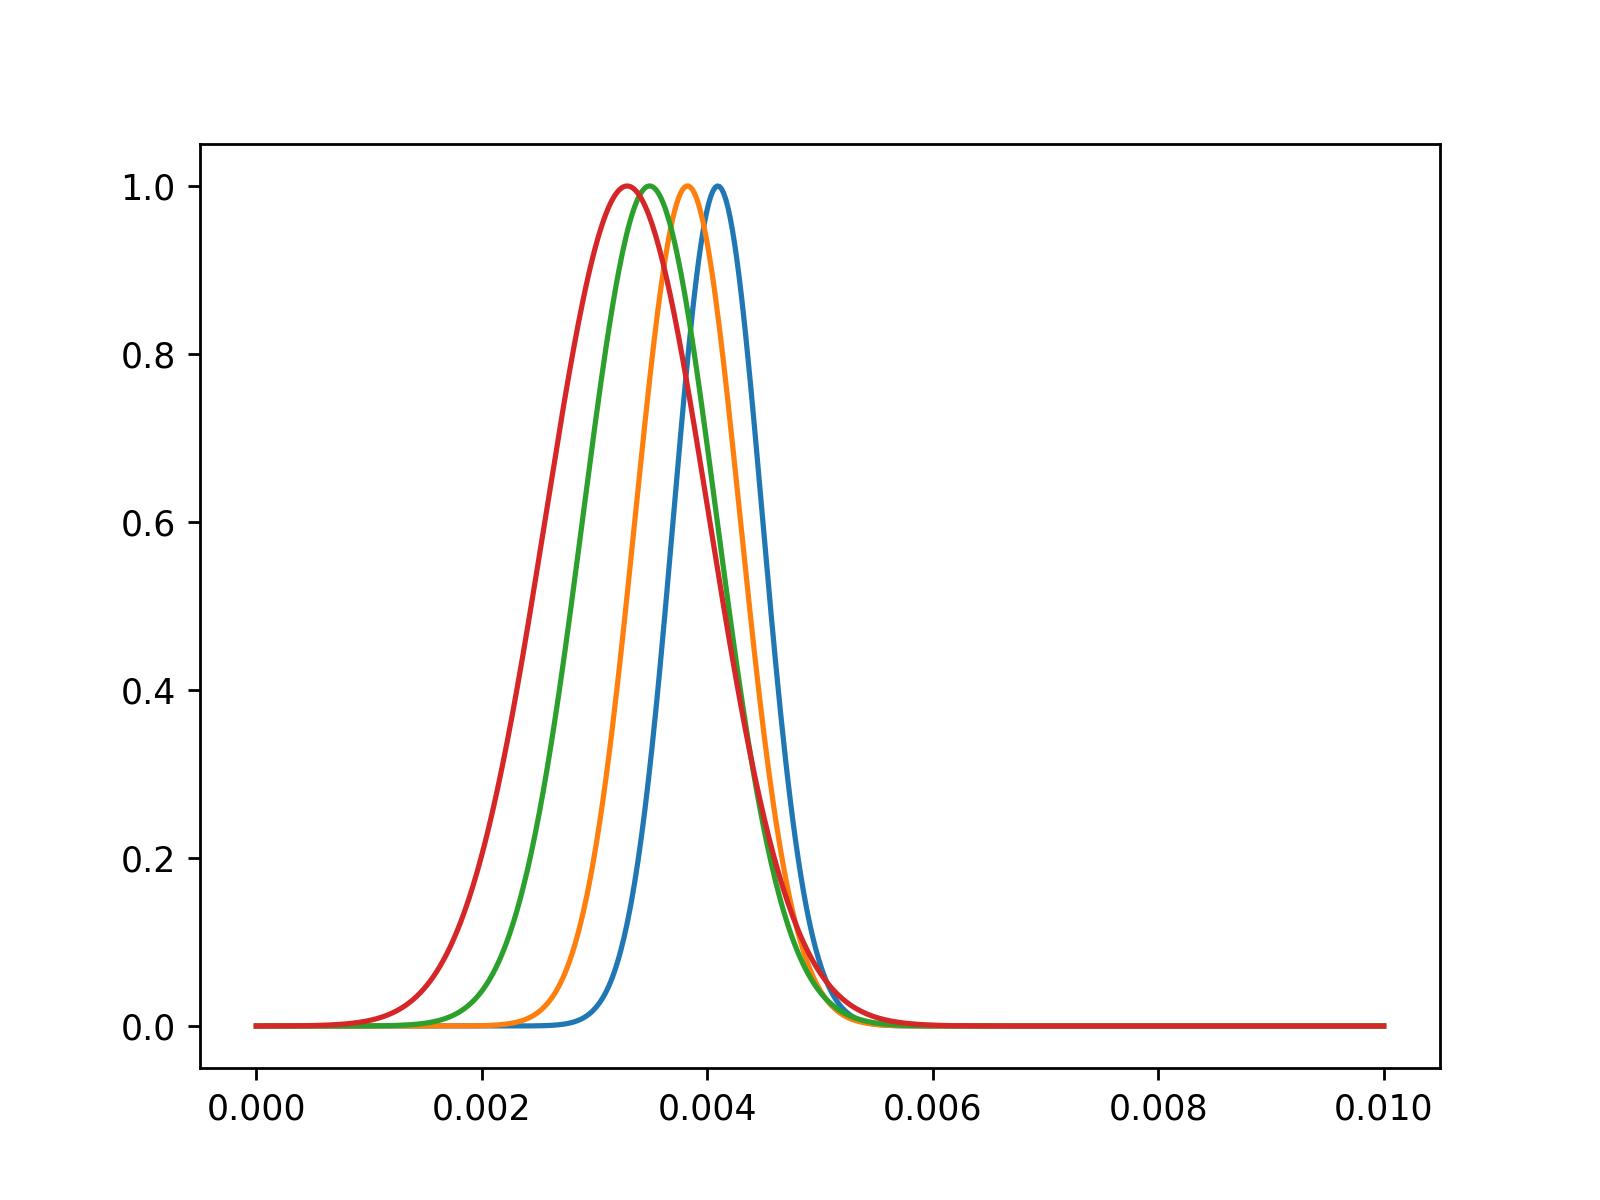

In [157]:
figure()
adr="cNILC00"
plot(chi_sq["r"],chi_sq[adr][0.0])
plot(chi_sq["r"],chi_sq[adr][0.3])
plot(chi_sq["r"],chi_sq[adr][0.6])
plot(chi_sq["r"],chi_sq[adr][0.9])

In [45]:
# datadict={key:rstat[key] for key in ["Case","$A_{\rm lens}$","$r_{\rm bias}$","$\sigma_r$","$r_{95}$"]}
# df_data=pd.DataFrame(datadict)
# df_data.set_index(["Case","$A_{\rm lens}$","$r_{\rm bias}$","$\sigma_r$","$r_{95}$"],inplace=True)
# print(df_data.to_latex(escape=False))

In [46]:
# defdict={key:unique(rstat[key]) for key in ["Case","Moments"]}
# df_def=pd.DataFrame(defdict)
# print(df_def.to_latex(escape=False))

In [47]:
# df1=pd.DataFrame(rstat)
# df1.set_index(["Case","Moments","$A_{\rm lens}$","$r_{\rm bias}$","$r_{95}$","$\sigma_r$"],inplace=False)

In [107]:
# print(df1.to_latex(column_format='lp{1.8cm}p{4cm}p{1.8cm}p{1.8cm}p{1.8cm}p{1.8cm}',escape=False,index=False))

In [48]:


# # df=pd.DataFrame(rstat)
# df.to_latex(escape=False)
# # with open('mytable.tex','w') as tf:
# #     tf.write(df.to_latex(index=False,escape=False))

In [227]:
Alens=0.3
ioff()
jpeg_path="../results/" + instr['simname'] + "/jpeg/"
gd.ensure_dir(jpeg_path)
for idx in range(len(instr["fnames"].keys())):
    adr="cNILC" + str(idx).zfill(2)
    filename=jpeg_path + "ps_and_bbposterir_" + adr + ".jpeg"
    fig, ax = subplots(nrows=1, ncols=2, figsize=(16, 5))
#     fig, ax = subplots(nrows=1, ncols=2, figsize=(10, 3))
    ax[0].plot(lbin,clbin["lens"],"k*-",ms=8,lw=3,label=r"Theory $r \in [10^{-2},10^{-3}]$",alpha=0.6)
    ax[0].fill_between(lbin,clbin["bb"]*1e-2,clbin["bb"]*1e-3,color="k",alpha=0.2)
    ax[0].plot(lbin,clbin["cmb"],"m.-",lw=3,label="True CMB")
    ax[0].plot(lbin,clbin["obs"][adr],"g--",lw=3,label="Observations")
    ax[0].plot(lbin,clbin["res"][adr],"r-",lw=2,label="Residuals")
    var=((Alens*clbin["cmb"])**2. + clbin["noise"][adr]**2. + clbin["res"][adr]**2.)
    var=var*(2./((2.*lbin+1)*deltaell*fsky))
    ax[0].plot(lbin,np.sqrt(var),"bo-",alpha=0.5,lw=3,label=r"Total Noise $[A_{\rm lens}=$" + str(Alens) + "]")
#     ax[0].plot(lbin,sqrt(((Alens*clbin["cmb"])**2. + clbin["noise"][adr]**2.)*(2./((2.*lbin+1)*deltaell*fsky))),"bo-",alpha=0.5,lw=3,label=r"Total Noise $[A_{\rm lens}=$" + str(Alens) + "]")
    ax[0].plot(lbin,clbin["noise"][adr]*sqrt((2./((2.*lbin+1)*deltaell*fsky))),'--',c="brown",lw=3,label="Instrument Noise")
    ax[0].legend(loc="upper left",ncol=2,title=instr['simname'] + " [Lmax=" + str(lmax) + "]",fontsize=8)
    # ax[0].set_title(instr["lbl"][adr])
    ax[0].set_ylim(1e-6,1e1)
    ax[0].set_xlabel(r"multipole, $\ell$",fontsize=10)
    ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/(2\pi)$" + "  $\mu K^2$",fontsize=10)
    ax[0].grid(which="both",linestyle="--",alpha=0.5)
    ax[0].semilogy()
    for Alens in Alens_array:
        ax[1].plot(chi_sq["r"],chi_sq[adr][Alens],lw=2,label=r"$A_{\rm lens}=" + str(Alens) + "$",c=color[Alens])
        ax[1].axvline(r_stat[adr][Alens][0],linestyle="-",alpha=0.5,c=color[Alens])
        ax[1].axvline(r_stat[adr][Alens][0] - r_stat[adr][Alens][1],linestyle="--",alpha=0.5,c=color[Alens])
        ax[1].axvline(r_stat[adr][Alens][0] + r_stat[adr][Alens][2],linestyle="--",alpha=0.5,c=color[Alens])
#     ax[1].plot(chi_sq["r"],chi_sq[adr][0.3],lw=2,label=r"$A_{\rm lens}=0.3$")
#     ax[1].plot(chi_sq["r"],chi_sq[adr][0.6],lw=2,label=r"$A_{\rm lens}=0.6$")
#     ax[1].plot(chi_sq["r"],chi_sq[adr][0.9],lw=2,label=r"$A_{\rm lens}=0.9$")
#     ax[1].legend(loc="lower right",fontsize=8,title=instr['simname'] )
    ax[1].set_xlabel("Tensor to scalar ratio (r)",fontsize=10)
    ax[1].set_ylabel(r"$e^{-\chi^2/2}$",fontsize=10)
    # ax[1].set_title(instr["lbl"][adr])
    ax[1].set_ylim(0,1.1)
    ax[1].grid(which="both",linestyle="--",alpha=0.4)
#     ax[1].semilogx()
    ax[1].set_xlim(1e-4,8e-3)
    ax[1].axvline(1e-3,color="k",linestyle="--",alpha=0.3)
    fig.suptitle(instr["lbl"][adr])
    
    savefig(filename,bbox_inches="tight")
    
cwd=os.getcwd()
os.chdir(jpeg_path)
cmd = "convert -delay 200 -loop 0 *.jpeg ../" +  instr['simname']
cmd = cmd + "_bbstat_evolve_moments_lmax" + str(lmax) + "_dl" + str(deltaell) + ".gif"
os.system(cmd)
# cmd="rm *.jpeg" ; os.system(cmd)
os.chdir(cwd)

In [164]:
# ioff()
# r,posmap=return_chi2_map(adr,Alens=Alens)
# locx=linspace(0,len(lbin)-1,5) ; tickx=linspace(min(lbin),max(lbin),5)
# locy=linspace(0,len(r)-1,3) ; ticky=logspace(log10(min(r)),log10(max(r)),3)

# jpeg_path="../results/" + instr['simname'] + "/jpeg/"
# gd.ensure_dir(jpeg_path)

# for idx in range(len(instr["fnames"].keys())):
#     adr="cNILC" + str(idx).zfill(2)
#     filename=jpeg_path + "ellbyell_bbposterir_" + adr + ".jpeg"
#     fig, ax = subplots(nrows=2, ncols=2, figsize=(13, 8))
#     # ax.set_xticks(locx)
#     i=0 ; j=0 ; Alens=0.0
#     r,posmap=return_chi2_map(adr,Alens=Alens)
#     img0=ax[i,j].imshow(posmap,aspect='auto',origin="lower",vmin=0,vmax=1)
# #     img0=ax[i,j].imshow(log10(posmap),aspect='auto',origin="lower",vmin=-7,vmax=0)
#     ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
#     ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
#     ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
#     # fig.colorbar(img0,ax=ax[i,j])
#     ax[i,j].set_aspect('auto')

#     i=0 ; j=1 ; Alens=0.3
#     r,posmap=return_chi2_map(adr,Alens=Alens)
#     img1=ax[i,j].imshow(posmap,aspect='auto',origin="lower",vmin=0,vmax=1)
# #     img1=ax[i,j].imshow(log10(posmap),aspect='auto',origin="lower",vmin=-7,vmax=0)
#     ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
#     ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
#     ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
#     # fig.colorbar(img1,ax=ax[i,j])
#     ax[i,j].set_aspect('auto')

#     i=1 ; j=0 ; Alens=0.6
#     r,posmap=return_chi2_map(adr,Alens=Alens)
#     img2=ax[i,j].imshow(posmap,aspect='auto',origin="lower",vmin=0,vmax=1)
# #     img2=ax[i,j].imshow(log10(posmap),aspect='auto',origin="lower",vmin=-7,vmax=0)
#     ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
#     ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
#     ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
#     # fig.colorbar(img2,ax=ax[i,j])
#     ax[i,j].set_aspect('auto')

#     i=1 ; j=1 ; Alens=0.9
#     r,posmap=return_chi2_map(adr,Alens=Alens)
#     img3=ax[i,j].imshow(posmap,aspect='auto',origin="lower",vmin=0,vmax=1)
# #     img3=ax[i,j].imshow(log10(posmap),aspect='auto',origin="lower",vmin=-7,vmax=0)
#     ax[i,j].set_xticks(locx) ; ax[i,j].set_xticklabels(tickx)
#     ax[i,j].set_yticks(locy) ; ax[i,j].set_yticklabels(ticky)
#     ax[i,j].set_title(r"$A_{\rm lens}=$" + str(Alens))
#     # fig.colorbar(img3,ax=ax[i,j])
#     ax[i,j].set_aspect('auto')

#     fig.colorbar(img0, ax=ax.ravel().tolist(), shrink=0.6)

#     fig.suptitle(instr["lbl"][adr])
#     savefig(filename,bbox_inches="tight")
    
# cwd=os.getcwd()
# os.chdir(jpeg_path)
# cmd = "convert -delay 200 -loop 0 *.jpeg ../" +  instr['simname']
# cmd = cmd + "_ellbyell_bbpost_evolve_moments_lmax" + str(lmax) + "_dl" + str(deltaell) + ".gif"
# os.system(cmd)
# cmd="rm *.jpeg" ; os.system(cmd)
# os.chdir(cwd)

In [175]:
# def return_chi2_iter(adr,Alens,rmin=1e-5,rmax=0.1,amp=1.1,like_cutoff=1e-3):
#     r_value=[rmin]
#     likemap=[]
    
#     var_other=(Alens*clbin["cmb"])**2. + clbin["noise"][adr]**2. + clbin["res"][adr]**2.
#     def return_likelihood(r):
#         ddiff=clbin["res"][adr]-r*clbin["bb"]
#         var=var_other +  (r*clbin["bb"])**2.
#         var=var*(2./((2.*lbin+1)*deltaell*fsky))
#         return exp(-np.sum(ddiff**2/var)/2.)
    
#     lhv=return_likelihood(rmin)
#     likemap=likemap + [lhv]
    
#     while lhv>like_cutoff or r_value[-1]<rmax:
#         r_value=r_value + [r_value[-1]*amp]
#         lhv=return_likelihood(r_value[-1])
# #         print r_value[-1],lhv
#         likemap=likemap + [lhv]
#     return np.array(r_value) ,np.array(likemap)

In [215]:
x=chi_sq["r"]
y=chi_sq["cNILC03"][0.0]
max_idx=np.where(y==max(y))[0][0]
rbias=x[max_idx]
xl=x[:max_idx+1] ; yl=y[:max_idx+1]
xh=x[max_idx:]   ; yh=y[max_idx:]

# Evaluating the lower limit
# This has an issue due to normalization
fn=interp1d(xl,yl,kind="cubic",assume_sorted=False)
norm=quad(fn,max(xl),min(xl))[0]

fn=interp1d(xl,yl/norm,kind="cubic",assume_sorted=False)
tempx=np.linspace(max(xl),min(xl),sampling)
cpdf=np.zeros_like(tempx)
for ix,xmin in enumerate(tempx):
    cpdf[ix]=quad(fn,max(xl),xmin)[0]

r_lower_bound=0
if len(cpdf[cpdf<sigma])>0:
    fn_cpdf=interp1d(cpdf,tempx,kind="cubic",assume_sorted=False,fill_value=max(tempx))
    r_lower_bound=rbias - fn_cpdf(sigma)*1.

# Evaluating the upper limit
fn=interp1d(xh,yh,kind="cubic",assume_sorted=False)
norm=quad(fn,min(xh),max(xh))[0]

fn=interp1d(xh,yh/norm,kind="cubic",assume_sorted=False)
tempx=np.linspace(min(xh),max(xh),sampling)
cpdf=np.zeros_like(tempx)
for ix,xmax in enumerate(tempx):
    cpdf[ix]=quad(fn,min(xh),xmax)[0]

r_upper_bound=max(xh)
if len(cpdf[cpdf<sigma])>0:
    fn_cpdf=interp1d(cpdf,tempx,kind="cubic",assume_sorted=False,fill_value=max(tempx))
    r_upper_bound=fn_cpdf(sigma)*1. - rbias

In [216]:
quad(fn,min(xh),rbias + r_upper_bound)[0]

0.6599992823428901

In [209]:
r_stat

{'cNILC00': {0.0: (0.004088948226294864,
   0.0003722812405094751,
   0.0003810126936006726),
  0.3: (0.0038157646612712484, 0.00043727870585928827, 0.0004499721103172886),
  0.6: (0.0034957755743632753, 0.0005670189306712986, 0.0005651246006863437),
  0.9: (0.003292437333007769, 0.000690920257464778, 0.0006929700937191728)},
 'cNILC01': {0.0: (0.0036946012051993025,
   0.0005029805932630781,
   0.0005047873956756108),
  0.3: (0.003593813663804626, 0.0005409593186407203, 0.0005418900851412284),
  0.6: (0.0034161232685855285, 0.0006291464781079739, 0.0006279783411860403),
  0.9: (0.003277294849923382, 0.0007344463881679502, 0.0007341475783432688)},
 'cNILC02': {0.0: (0.003995780301895269,
   0.0003819926363548727,
   0.00038137698350378633),
  0.3: (0.0036946012051993025, 0.00044841558121473364, 0.0004452679502259891),
  0.6: (0.003277294849923382, 0.0005649707166994261, 0.0005721282960499206),
  0.9: (0.0030163343472591974, 0.0006950402091638326, 0.000696821521096294)},
 'cNILC03': {0.

<IPython.core.display.Javascript object>


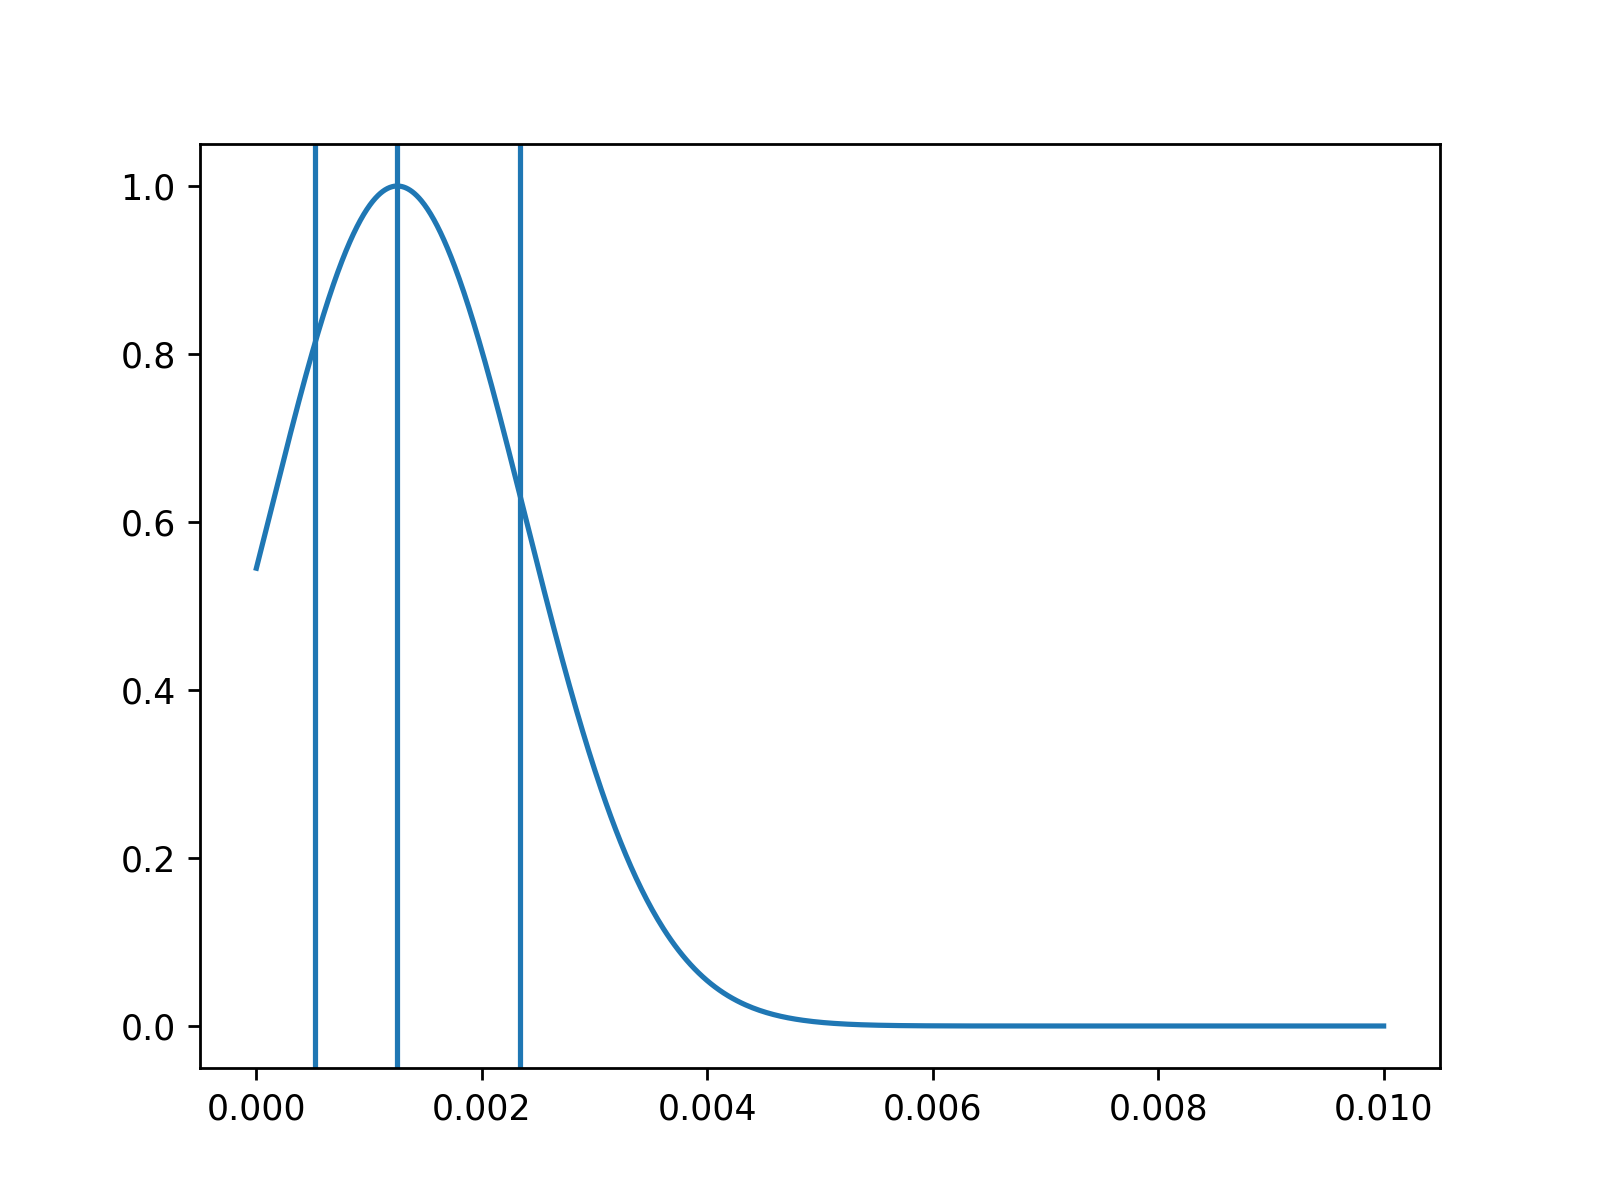

In [224]:
adr="cNILC07" ; Alens=0.3
x=chi_sq["r"]
y=chi_sq[adr][Alens]
ion()
figure()
plot(x,y)
axvline(r_stat[adr][Alens][0])
axvline(r_stat[adr][Alens][0]-r_stat[adr][Alens][1])
axvline(r_stat[adr][Alens][0]+r_stat[adr][Alens][2])

In [112]:
rub

array(0.00466835)

In [108]:
xl=x[:max_idx+1] ; yl=y[:max_idx+1]
xh=x[max_idx:]   ; yh=y[max_idx:]

# Evaluating the lower limit
fn=interp1d(xl,yl,kind="cubic",assume_sorted=False)
norm=quad(fn,max(xl),min(xl))[0]

fn=interp1d(xl,yl/norm,kind="cubic",assume_sorted=False)
tempx=np.linspace(max(xl),min(xl),sampling)
cpdf=np.zeros_like(tempx)
for ix,xmin in enumerate(tempx):
    cpdf[ix]=quad(fn,max(xl),xmin)[0]

r_lower_bound=0
if len(cpdf[cpdf<sigma])>0:
    fn_cpdf=interp1d(cpdf,tempx,kind="cubic",assume_sorted=False,fill_value=max(tempx))
    r_lower_bound=fn_cpdf(sigma)

<IPython.core.display.Javascript object>


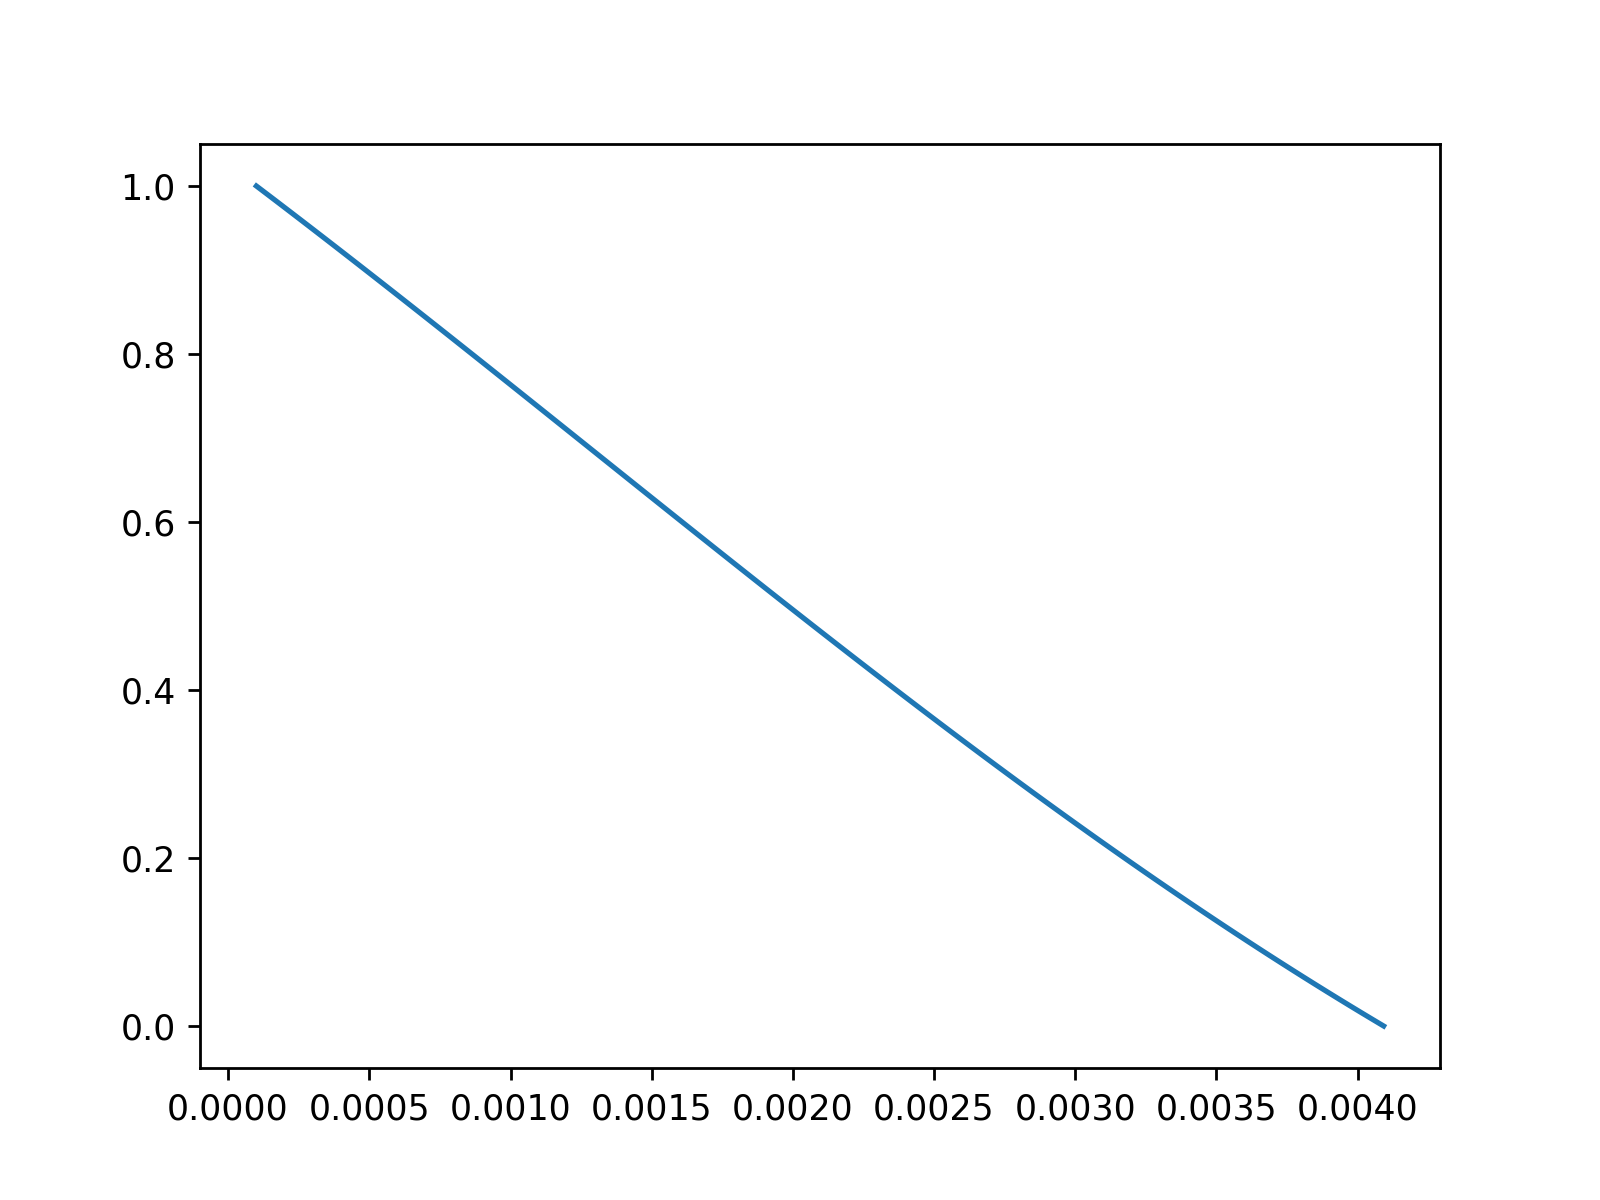

In [109]:
figure()
plot(tempx,cpdf)

## Old plots

In [10]:
# Alens=0.3

# ioff()
# jpeg_path="../results/" + instr['simname'] + "/jpeg/ps/"
# gd.ensure_dir(jpeg_path)

# for idx in range(len(instr["fnames"].keys())):
#     adr="cNILC" + str(idx).zfill(2)
#     filename=jpeg_path + "ps_" + adr + ".jpeg"
#     figure()
#     plot(lbin,clbin["lens"],"k*-",ms=8,lw=3,label=r"Theory $r \in [10^{-2},10^{-3}]$",alpha=0.6)
#     fill_between(lbin,clbin["bb"]*1e-2,clbin["bb"]*1e-3,color="k",alpha=0.2)
#     plot(lbin,clbin["cmb"],"m.-",lw=3,label="True CMB")
#     plot(lbin,clbin["obs"][adr],"g--",lw=3,label="Observations")
#     plot(lbin,clbin["res"][adr],"r-",lw=2,label="Residuals")
#     plot(lbin,sqrt(((Alens*clbin["cmb"])**2. + clbin["noise"][adr]**2.)*(2./((2.*lbin+1)*deltaell*fsky))),"bo-",alpha=0.5,lw=3,label=r"Total Noise $[A_{\rm lens}=$" + str(Alens) + "]")
#     plot(lbin,clbin["noise"][adr]*sqrt((2./((2.*lbin+1)*deltaell*fsky))),'--',c="brown",lw=3,label="Instrument Noise")
#     legend(loc="upper right",ncol=2,title=instr['simname'])
#     title(instr["lbl"][adr])
#     semilogy()
#     ylim(1e-6,1e1)
#     xlabel(r"multipole, $\ell$",fontsize=13)
#     ylabel(r"$\ell(\ell+1)C_{\ell}/(2\pi)$" + "  $\mu K^2$",fontsize=13)
#     grid(linestyle="--",alpha=0.5)
#     savefig(filename,bbox_inches="tight")
    
# cwd=os.getcwd()
# os.chdir(jpeg_path)
# cmd = "convert -delay 200 -loop 0 *.jpeg ../../" +  instr['simname'] + "_ps_evolve_moments.gif"
# os.system(cmd)
# os.chdir(cwd)

In [11]:
# jpeg_path="../results/" + instr['simname'] + "/jpeg/chi2/"
# gd.ensure_dir(jpeg_path)

# ioff()
# for idx in range(len(instr["fnames"].keys())):
#     adr="cNILC" + str(idx).zfill(2)
#     filename=jpeg_path + "r_likelihood_" + adr + ".jpeg"

#     r1,chi21=return_chi2(adr,Alens=0)
#     r2,chi22=return_chi2(adr,Alens=0.3)
#     r3,chi23=return_chi2(adr,Alens=0.6)
#     r4,chi24=return_chi2(adr,Alens=1.)
#     figure()
#     plot(r1,chi21,lw=2,label=r"$A_{\rm lens}=0$")
#     plot(r2,chi22,lw=2,label=r"$A_{\rm lens}=0.3$")
#     plot(r3,chi23,lw=2,label=r"$A_{\rm lens}=0.6$")
#     plot(r3,chi24,lw=2,label=r"$A_{\rm lens}=0.9$")
#     legend(loc="lower right",fontsize=13,title=instr['simname'])
#     xlabel("Tensor to scalar ratio (r)",fontsize=13)
#     ylabel(r"$e^{-\chi^2/2}$",fontsize=13)
#     title(instr["lbl"][adr])
#     ylim(0,1.1)
#     grid(which="both",linestyle="--",alpha=0.4)
#     semilogx()
#     savefig(filename,bbox_inches="tight")

# cwd=os.getcwd()
# os.chdir(jpeg_path)
# cmd = "convert -delay 200 -loop 0 *.jpeg ../../" +  instr['simname'] + "_r_posterior_evolve_moments.gif"
# os.system(cmd)
# os.chdir(cwd)